In [1]:
import torch
from torch import nn 
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
def show_tensor_images(image_tensor,num_images=25,size=(1,28,28)):
    image_unflat = image_tensor.detach().cpu().view(-1,*size)
    image_grid = make_grid(image_unflat[:num_images],nrow=5)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()

In [9]:
class Generator(nn.Module):
    def __init__(self,z_dim=10,im_chan=1,hidden_dim=64):
        super(Generator,self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim,hidden_dim*4),
            self.make_gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
            self.make_gen_block(hidden_dim*2,hidden_dim),
            self.make_gen_block(hidden_dim,im_chan,kernel_size=4,final_layer=True)
        )
    
    def make_gen_block(self,input_channels,output_channels,kernel_size=3,stride=2,final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
                nn.Tanh()
            )
        
    def unsqueeze_noise(self,noise):
        return noise.view(len(noise),self.z_dim,1,1)
    

    def forward(self,noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)
    

def get_noise(n_samples,z_dim,device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

In [10]:
class Discriminator(nn.Module):
    def __init__(self,im_chan=1,hidden_dim=16):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan,hidden_dim),
            self.make_disc_block(hidden_dim,hidden_dim*2),
            self.make_disc_block(hidden_dim*2,1,final_layer=True)
        )

    def make_disc_block(self,input_channels,output_channels,kernel_size=4,stride=2,final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2,inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride)
            )
        
    def forward(self,image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred),-1)

In [11]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [12]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  6%|▌         | 29/469 [00:00<00:12, 34.47it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500: Generator loss: 0.9224480061531072, discriminator loss: 0.4988351458013058


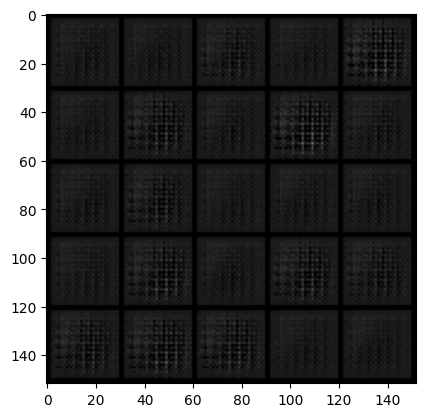

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


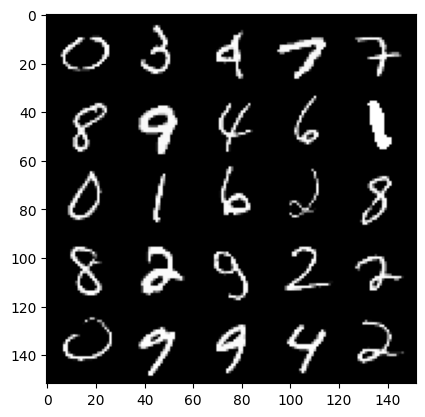

 13%|█▎        | 61/469 [00:02<00:17, 23.77it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: 2.420075666189194, discriminator loss: 0.10725035804510108


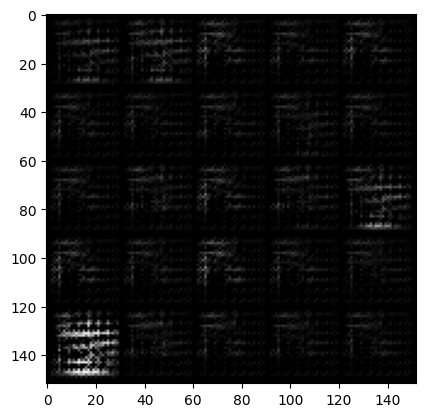

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


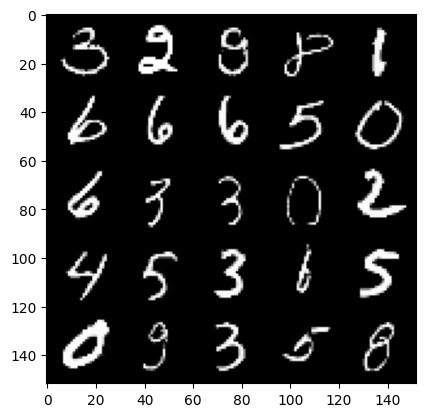

 20%|█▉        | 93/469 [00:06<00:40,  9.17it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500: Generator loss: 3.022606219142674, discriminator loss: 0.16511268706992271


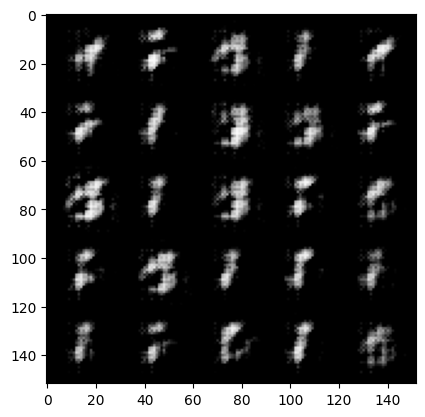

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


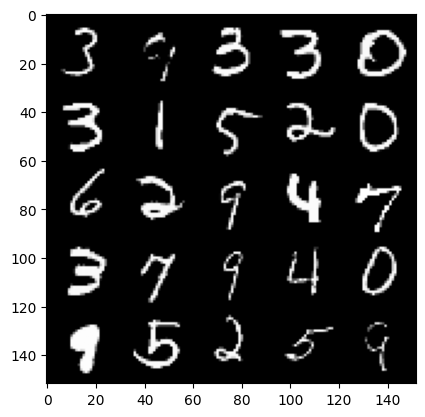

 26%|██▌       | 122/469 [00:05<00:12, 27.31it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: 1.4135805426985022, discriminator loss: 0.4533386278301478


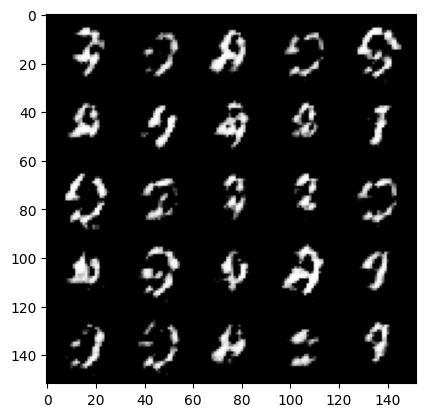

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


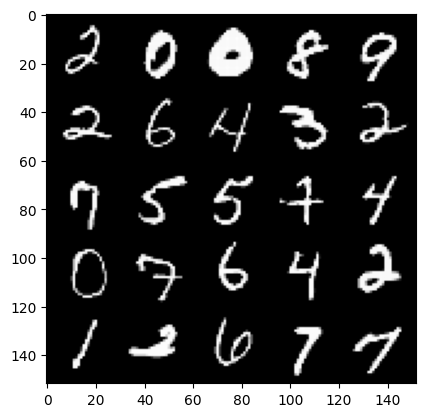

 33%|███▎      | 155/469 [00:07<00:30, 10.14it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500: Generator loss: 1.1505789596438412, discriminator loss: 0.5041605567932131


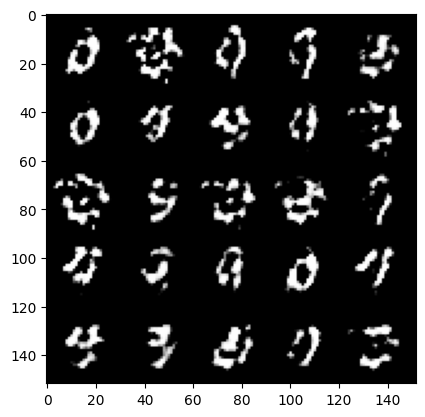

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


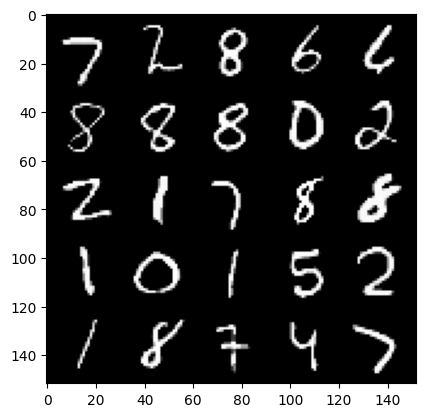

 39%|███▉      | 185/469 [00:16<00:27, 10.50it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000: Generator loss: 0.984432574599981, discriminator loss: 0.5524278767108916


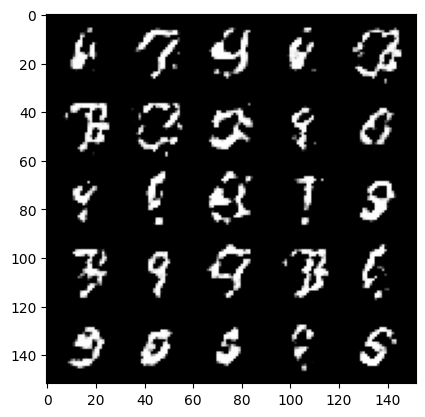

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


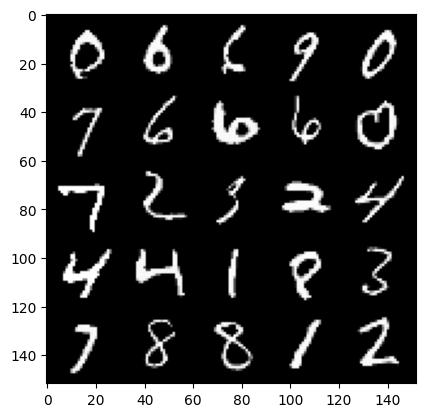

 46%|████▋     | 217/469 [00:07<00:10, 23.48it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3500: Generator loss: 0.9080106281042093, discriminator loss: 0.5879370985031124


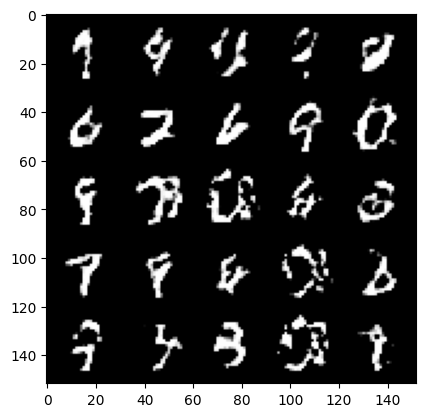

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


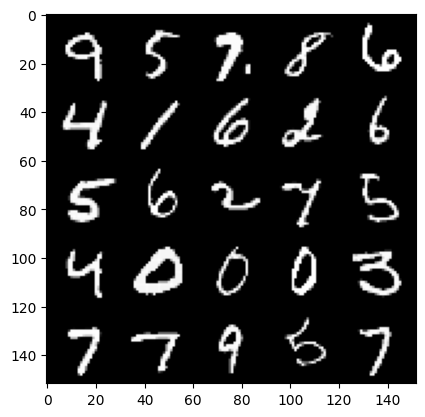

 53%|█████▎    | 247/469 [00:09<00:08, 26.36it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000: Generator loss: 0.8774690907001489, discriminator loss: 0.6067732087373735


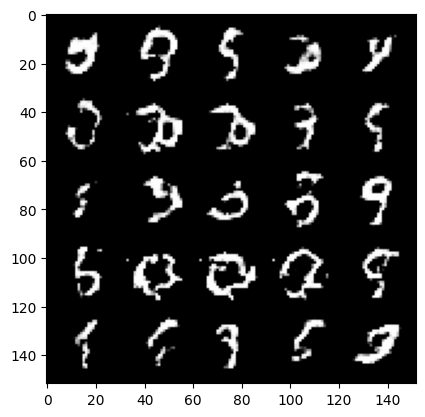

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


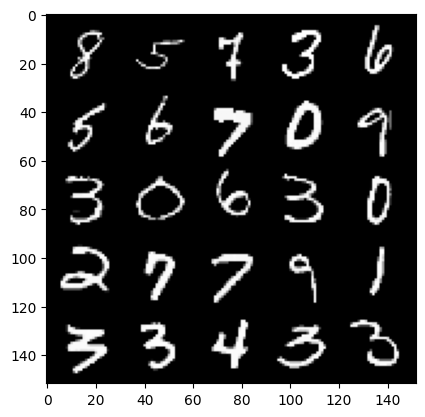

 59%|█████▉    | 276/469 [00:09<00:05, 32.63it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4500: Generator loss: 0.8333359937071803, discriminator loss: 0.6278987733125684


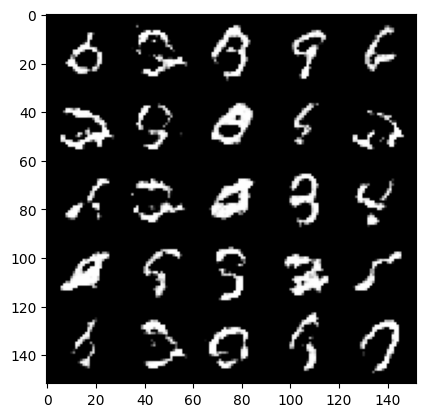

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


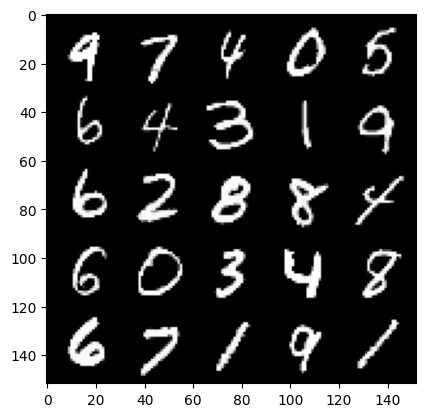

 66%|██████▌   | 310/469 [00:19<00:16,  9.42it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000: Generator loss: 0.8176739398241039, discriminator loss: 0.6435323961973192


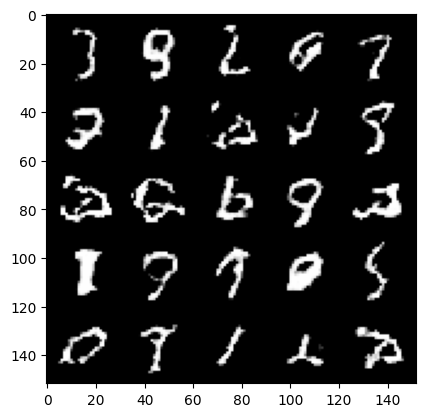

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


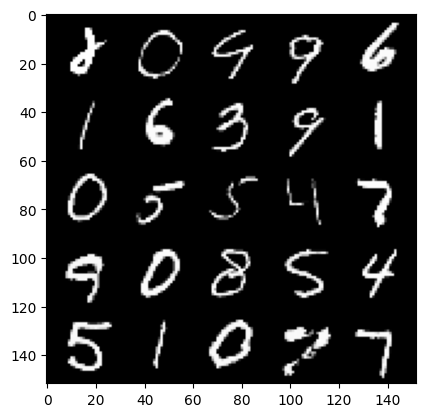

 72%|███████▏  | 340/469 [00:15<00:10, 12.26it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5500: Generator loss: 0.7944715288281438, discriminator loss: 0.6535937066078188


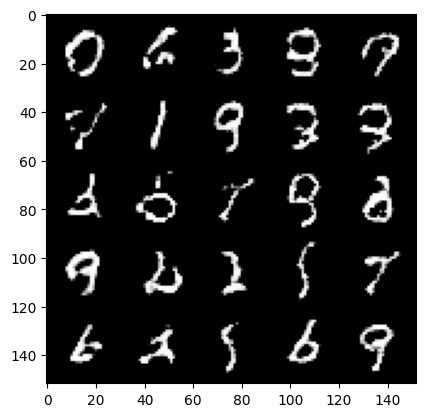

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


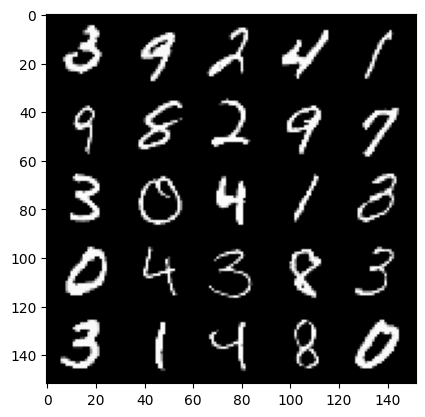

 79%|███████▉  | 371/469 [00:30<00:03, 27.13it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000: Generator loss: 0.7793614511489867, discriminator loss: 0.6621216528415682


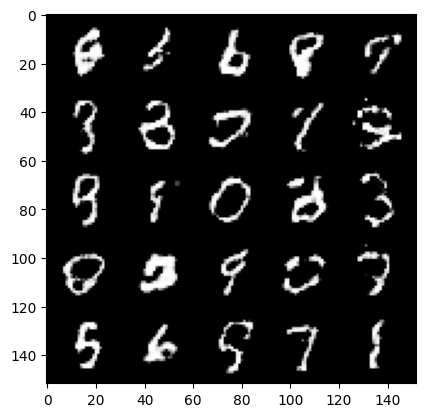

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


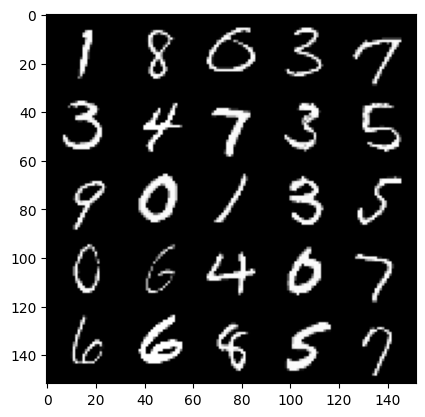

 11%|█         | 50/469 [00:01<00:16, 25.36it/s]


KeyboardInterrupt: 

In [13]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):

    for real,_ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size,z_dim,device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss)/2
        
        mean_discriminator_loss += disc_loss.item()/display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()


        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size,z_dim,device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        mean_generator_loss += gen_loss.item()/display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

torch.save(gen.state_dict(), 'generator.pth')